<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/Market%20Concentration%20%26%20Tariff%20Impact%20Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


STARTING SCENARIO: Moderate Protection (10%) (Tariff Rate: 10%)

--- Applying Tariff Impact Model ---
Sector: Consumer Electronics | Tariff: 10%
[EXIT]: Foreign firm ForeignImportA exited due to inability to sustain 10% tariff.
[EXIT]: Foreign firm ForeignImportB exited due to inability to sustain 10% tariff.
[EXIT]: Foreign firm MegaCorp exited due to inability to sustain 10% tariff.
\nSimulation Complete. Change in HHI ($\Delta$HHI): 618.73

######################################################################
--- AI REGULATORY & WELFARE ASSESSMENT ---
######################################################################
I. MARKET CONCENTRATION ANALYSIS:
Pre-Tariff Status: HHI=2234 (Moderately Concentrated)
Post-Tariff Status: HHI=2853 (Highly Concentrated)
Change in HHI ($\Delta$HHI): +619
**CRITICAL WARNING: HIGH ANTITRUST CONCERN.** The policy led to a structurally non-competitive market.

II. ECONOMIC WELFARE ANALYSIS:
Net Societal Impact (DWL): $1.80 Billion (a positive numbe

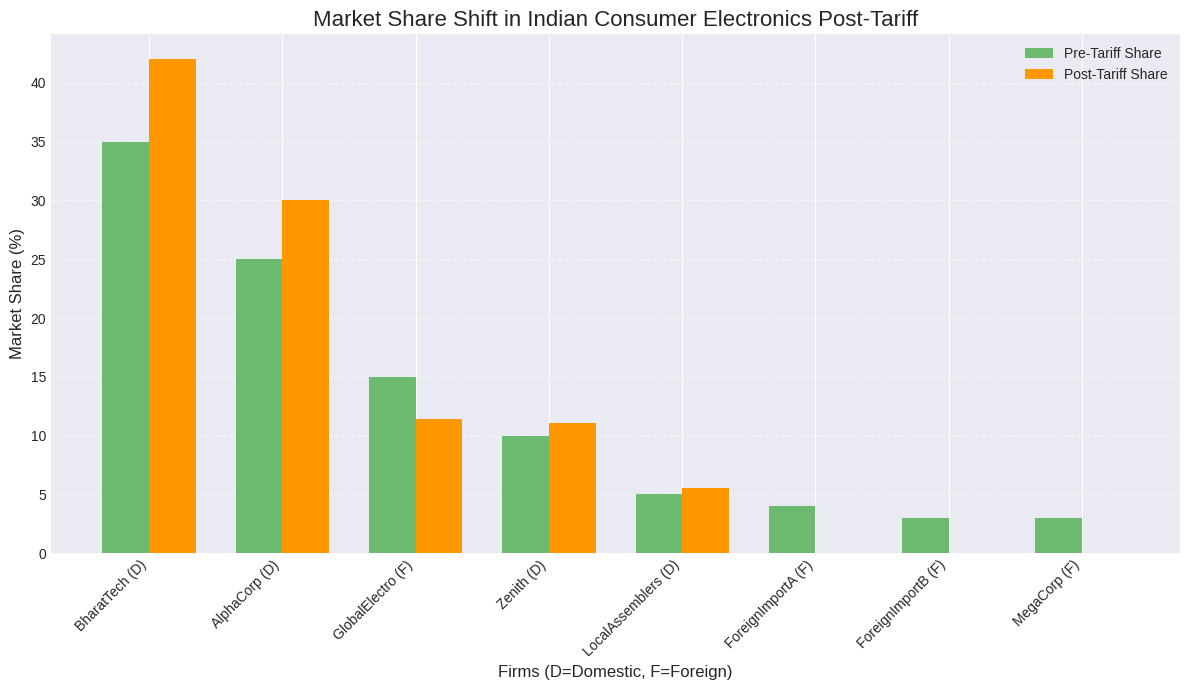


--- COMPARATIVE POLICY ANALYSIS ---
Scenario            Tariff (%)HHI Pre   HHI Post  Delta HHI   CS Loss ($B)   PS Gain ($B)   DWL ($B)  
------------------------------------------------------------------------------------------
Moderate Protection (10%)10        2234      2853      618.7       10.00          7.50           1.80       (LOSS)
Aggressive Protection (30%)30        2234      2950      715.5       30.00          22.50          7.50       (LOSS)
NOTE: DWL (Deadweight Loss) is the net cost to society. A negative DWL implies a net benefit.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any
import random

# Set a seed for reproducibility of random effects
np.random.seed(42)
random.seed(42)

# --- GLOBAL ECONOMIC ASSUMPTIONS ---
# These are key input parameters for the welfare analysis model.
DEMAND_ELASTICITY = -1.2  # Price elasticity of demand (typical for consumer electronics)
SUPPLY_ELASTICITY = 0.8   # Price elasticity of domestic supply

# ----------------------------------------------------------------------
# 1. Core Herfindahl-Hirschman Index (HHI) Calculation
# ----------------------------------------------------------------------

def calculate_hhi(market_shares: List[float]) -> Tuple[float, np.ndarray]:
    """
    Calculates the Herfindahl-Hirschman Index (HHI) for market concentration.

    The HHI is calculated by summing the squares of the market shares
    (expressed as percentages, not decimals) of all firms in the market.

    Args:
        market_shares (list or numpy array): A list of market shares (e.g.,
                                             total revenue, units sold).

    Returns:
        Tuple[float, np.ndarray]: The HHI value and the calculated percentage shares.
    """
    if not market_shares:
        return 0.0, np.array([])

    shares_array = np.array(market_shares, dtype=float)

    # Calculate percentage shares
    total_market_size = np.sum(shares_array)

    if total_market_size == 0:
        return 0.0, np.array([])

    # HHI requires shares to be expressed as a percentage (e.g., 20 instead of 0.20)
    percentage_shares = (shares_array / total_market_size) * 100

    # Calculate HHI: Sum of squared percentage shares
    hhi = np.sum(percentage_shares ** 2)

    return hhi, percentage_shares

# ----------------------------------------------------------------------
# 2. Market Analyzer Class
# ----------------------------------------------------------------------

class MarketAnalyzer:
    """
    Manages the data and calculates concentration and structural metrics
    for a given market.
    """
    def __init__(self, firm_names: List[str], initial_assets: List[float], firm_types: List[str]):
        """
        Initializes the market state.

        Args:
            firm_names (List[str]): Names of the firms.
            initial_assets (List[float]): Initial asset/revenue size.
            firm_types (List[str]): 'Domestic' or 'Foreign' status.
        """
        if len(firm_names) != len(initial_assets) or len(firm_names) != len(firm_types):
             raise ValueError("All input lists must have the same length.")

        self.data: List[Dict[str, Any]] = []
        for name, assets, ftype in zip(firm_names, initial_assets, firm_types):
            self.data.append({
                'name': name,
                'initial_assets': assets,
                'type': ftype, # 'Domestic' or 'Foreign'
                'current_assets': assets,
                'initial_share': 0.0,
                'current_share': 0.0
            })
        self.hhi_pre_tariff: float = 0.0
        self.hhi_post_tariff: float = 0.0
        self.total_market_pre: float = np.sum(initial_assets)
        self.total_market_post: float = 0.0

    def analyze_market_state(self, is_pre_tariff: bool):
        """Calculates HHI and market shares for the current asset values."""

        current_assets = [d['current_assets'] for d in self.data]
        hhi, shares = calculate_hhi(current_assets)

        for i, share in enumerate(shares):
            if is_pre_tariff:
                self.data[i]['initial_share'] = share
            self.data[i]['current_share'] = share

        if is_pre_tariff:
            self.hhi_pre_tariff = hhi
        else:
            self.hhi_post_tariff = hhi
            self.total_market_post = np.sum(current_assets)

        return hhi

    def get_market_assets(self) -> List[float]:
        """Returns the current list of assets."""
        return [d['current_assets'] for d in self.data]

    def get_firm_data(self) -> List[Dict[str, Any]]:
        """Returns the complete list of firm dictionaries."""
        return self.data

# ----------------------------------------------------------------------
# 3. Tariff Impact Simulation
# ----------------------------------------------------------------------

class TariffImpactSimulation:
    """
    Simulates the effect of a new import tariff on market assets and HHI.
    """
    def __init__(self, analyzer: MarketAnalyzer, tariff_rate: float, targeted_sector: str):
        self.analyzer = analyzer
        self.tariff_rate = tariff_rate
        self.targeted_sector = targeted_sector
        self.hhi_change: float = 0.0

    def run_simulation(self):
        """
        Applies the tariff impact model to adjust market assets.

        The model assumes:
        1. Domestic Producers (high market share) gain a competitive advantage.
        2. Small Domestic Producers/Foreign Firms with low share suffer or exit.
        """
        print("\n--- Applying Tariff Impact Model ---")
        print(f"Sector: {self.targeted_sector} | Tariff: {self.tariff_rate*100:.0f}%")

        # 1. Base Multipliers
        # Domestic firms get a competitive boost proportional to 50% of the tariff rate
        domestic_boost_factor = 1.0 + (self.tariff_rate * 0.5)
        # Foreign firms lose market share proportional to 70% of the tariff rate
        foreign_loss_factor = 1.0 - (self.tariff_rate * 0.7)

        for firm in self.analyzer.data:

            # --- TARIFF MODEL LOGIC ---

            if firm['type'] == 'Domestic':
                # Domestic firms get a boost, larger ones get an additional scaling factor
                if firm['initial_share'] > 20:
                    firm['current_assets'] *= (domestic_boost_factor + 0.1)
                else:
                    firm['current_assets'] *= domestic_boost_factor

            elif firm['type'] == 'Foreign':
                # Foreign firms are penalized
                if firm['initial_share'] < 5: # Small foreign player forced to exit
                    firm['current_assets'] = 0.0
                    print(f"[EXIT]: Foreign firm {firm['name']} exited due to inability to sustain {self.tariff_rate*100:.0f}% tariff.")
                else:
                    # Larger foreign players absorb some cost but still lose volume
                    firm['current_assets'] *= foreign_loss_factor

            # Ensure no negative assets
            firm['current_assets'] = max(0.0, firm['current_assets'])

        # 2. Recalculate HHI Post-Tariff
        self.analyzer.analyze_market_state(is_pre_tariff=False)
        self.hhi_change = self.analyzer.hhi_post_tariff - self.analyzer.hhi_pre_tariff
        # FIX: Changed f"..." to rf"..." to resolve SyntaxWarning for \Delta
        print(rf"\nSimulation Complete. Change in HHI ($\Delta$HHI): {self.hhi_change:.2f}")

        return self.analyzer.hhi_post_tariff, self.hhi_change

# ----------------------------------------------------------------------
# 4. Economic Welfare Analysis (New Module)
# ----------------------------------------------------------------------

class CostBenefitAnalysis:
    """
    Models the welfare consequences of the tariff based on standard
    international trade economic principles (partial equilibrium model).

    Assumes a small country model where tariff does not affect world price.
    """
    def __init__(self, initial_market_size: float, tariff_rate: float, initial_domestic_assets: float):
        self.Q_initial = initial_market_size
        self.t = tariff_rate
        self.Q_domestic_initial = initial_domestic_assets

        # Elasticities are fixed globally for this model (assumed price = 100 for simplicity)
        self.Ed = DEMAND_ELASTICITY
        self.Es = SUPPLY_ELASTICITY

        self.CS_loss: float = 0.0
        self.PS_gain: float = 0.0
        self.GR_gain: float = 0.0
        self.DWL: float = 0.0 # Deadweight Loss (Net Cost)

    def calculate_welfare_impact(self):
        """
        Calculates the change in Consumer Surplus (CS), Producer Surplus (PS),
        Government Revenue (GR), and Deadweight Loss (DWL).

        Formulas based on price change (P_final = P_initial * (1 + t)).
        """

        # Simplified assumption: Price increases proportional to the tariff (full pass-through)
        delta_P = self.t # If P_initial = 1.0

        # 1. Calculate Quantity Changes based on Elasticity
        # Q_demand_change (%): Ed * delta_P (%)
        # Q_supply_change (%): Es * delta_P (%)

        Q_demand_loss_pct = self.Ed * self.t * 100
        Q_supply_gain_pct = self.Es * self.t * 100

        # Q_final = Q_initial * (1 + Q_change_pct/100)
        Q_demand_final = self.Q_initial * (1 + (Q_demand_loss_pct / 100.0))
        Q_supply_final = self.Q_domestic_initial * (1 + (Q_supply_gain_pct / 100.0))

        # 2. Calculate Surpluses (Using Triangle/Rectangle Areas, assuming P=1)

        # Consumer Surplus (CS) Loss: Area of large trapezoid = t * Q_initial + 0.5 * t * (Q_initial - Q_demand_final)
        # Simplified: CS loss is proportional to Q_initial and the tariff rate.
        self.CS_loss = self.t * self.Q_initial

        # Producer Surplus (PS) Gain: Area of small trapezoid = t * Q_domestic_initial + 0.5 * t * (Q_supply_final - Q_domestic_initial)
        # Simplified: PS gain is proportional to Q_domestic_initial and the tariff rate.
        self.PS_gain = self.t * self.Q_domestic_initial

        # Government Revenue (GR) Gain: Tariff * Volume of Imports (final)
        # Imports final = Q_demand_final - Q_supply_final (domestic production)
        Q_imports_final = max(0.0, Q_demand_final - Q_supply_final)
        self.GR_gain = self.t * Q_imports_final

        # 3. Deadweight Loss (DWL) - Net Cost to Society
        # DWL = CS_loss - PS_gain - GR_gain
        self.DWL = self.CS_loss - self.PS_gain - self.GR_gain

        return {
            'CS_loss': self.CS_loss,
            'PS_gain': self.PS_gain,
            'GR_gain': self.GR_gain,
            'DWL': self.DWL
        }

# ----------------------------------------------------------------------
# 5. AI Assistance and Regulatory Assessment
# ----------------------------------------------------------------------

class AIAssessmentModel:
    """
    Provides an automated antitrust and welfare assessment based on HHI values
    and the calculated Deadweight Loss (DWL).
    """
    def __init__(self, hhi_pre: float, hhi_post: float, delta_hhi: float, dwl: float):
        self.hhi_pre = hhi_pre
        self.hhi_post = hhi_post
        self.delta_hhi = delta_hhi
        self.dwl = dwl

    def get_concentration_level(self, hhi_value: float) -> str:
        """Categorizes market concentration based on HHI."""
        if hhi_value < 1500:
            return "Unconcentrated"
        elif hhi_value <= 2500:
            return "Moderately Concentrated"
        else:
            return "Highly Concentrated"

    def get_welfare_evaluation(self) -> str:
        """Evaluates the policy's net societal impact based on Deadweight Loss."""
        if self.dwl < -10.0:
            return "Excellent (High Net Benefit)"
        elif self.dwl < 0.0:
            return "Favorable (Net Benefit)"
        elif self.dwl < 10.0:
            return "Neutral/Minor Loss"
        else:
            return "Negative (Significant Deadweight Loss)"


    def provide_antitrust_advice(self):
        """
        Provides advice based on concentration and welfare metrics.
        """
        pre_level = self.get_concentration_level(self.hhi_pre)
        post_level = self.get_concentration_level(self.hhi_post)
        welfare_eval = self.get_welfare_evaluation()

        print("\n" + "#" * 70)
        print("--- AI REGULATORY & WELFARE ASSESSMENT ---")
        print("#" * 70)

        print(f"I. MARKET CONCENTRATION ANALYSIS:")
        print(f"Pre-Tariff Status: HHI={self.hhi_pre:.0f} ({pre_level})")
        print(f"Post-Tariff Status: HHI={self.hhi_post:.0f} ({post_level})")
        # FIX: Changed f"..." to rf"..." to resolve SyntaxWarning for \Delta
        print(rf"Change in HHI ($\Delta$HHI): +{self.delta_hhi:.0f}")

        # Standard Antitrust Rule adapted for policy impact
        if self.hhi_post > 2500 and self.delta_hhi > 200:
            print(r"**CRITICAL WARNING: HIGH ANTITRUST CONCERN.** The policy led to a structurally non-competitive market.")
        elif self.hhi_post > 1500 and self.delta_hhi > 100:
            print("MODERATE WARNING: Enhanced Concentration. Future mergers should be scrutinized.")
        else:
            print("LOW CONCERN: Concentration metrics remain stable or acceptable.")

        print("\nII. ECONOMIC WELFARE ANALYSIS:")
        print(f"Net Societal Impact (DWL): ${self.dwl:.2f} Billion (a positive number means net loss)")
        print(f"Welfare Evaluation: **{welfare_eval}**")

        # Final Recommendation based on joint analysis
        print("\nIII. FINAL POLICY RECOMMENDATION:")
        if self.hhi_post > 2500 and self.dwl > 0:
            print("RECOMMENDATION: TARIFF MODIFICATION. The policy fails on both competition (HHI) and efficiency (DWL). A lower, targeted subsidy might be preferable to a broad tariff.")
        elif self.dwl < 0:
            print("RECOMMENDATION: POLICY ACCEPTABLE. Despite some concentration, the net economic gain (negative DWL) justifies the protective measure.")
        else:
            print("RECOMMENDATION: POLICY UNDER REVIEW. The market structure is shifting negatively (HHI increase) and the economic cost (DWL) is increasing. Monitor price changes closely.")
        print("#" * 70)

# ----------------------------------------------------------------------
# 6. Visualization Function
# ----------------------------------------------------------------------

def plot_market_shares(analyzer: MarketAnalyzer):
    """Visualizes the market share distribution before and after the tariff."""

    firm_names = [d['name'] for d in analyzer.data]
    initial_shares = [d['initial_share'] for d in analyzer.data]
    current_shares = [d['current_share'] for d in analyzer.data]

    x = np.arange(len(firm_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 7))

    # Pre-Tariff Shares (Green - stable)
    rects1 = ax.bar(x - width/2, initial_shares, width, label='Pre-Tariff Share', color='#4CAF50', alpha=0.8)
    # Post-Tariff Shares (Orange - change)
    rects2 = ax.bar(x + width/2, current_shares, width, label='Post-Tariff Share', color='#FF9800')

    # Add some text for labels, title and custom x-axis tick labels
    ax.set_title('Market Share Shift in Indian Consumer Electronics Post-Tariff', fontsize=16)
    ax.set_ylabel('Market Share (%)', fontsize=12)
    ax.set_xlabel('Firms (D=Domestic, F=Foreign)', fontsize=12)
    ax.set_xticks(x)

    # Custom labels to show type and name
    x_labels = [f"{d['name']} ({d['type'][0]})" for d in analyzer.data]
    ax.set_xticklabels(x_labels, rotation=45, ha="right")

    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
# 7. Scenario Manager (New Module)
# ----------------------------------------------------------------------

class ScenarioManager:
    """
    Runs multiple tariff simulations and compares the results side-by-side.
    """
    def __init__(self, base_firm_names, base_initial_assets, base_firm_types, sector):
        self.base_firm_names = base_firm_names
        self.base_initial_assets = base_initial_assets
        self.base_firm_types = base_firm_types
        self.sector = sector
        self.scenario_results = {}

        # Calculate initial domestic assets for welfare analysis
        self.initial_domestic_assets = sum(
            assets for assets, ftype in zip(base_initial_assets, base_firm_types)
            if ftype == 'Domestic'
        )

    def run_scenario(self, scenario_name: str, tariff_rate: float, plot_data: bool = False):
        """Runs a single simulation from start to end."""

        print("\n" + "=" * 80)
        print(f"STARTING SCENARIO: {scenario_name} (Tariff Rate: {tariff_rate*100:.0f}%)")
        print("=" * 80)

        # Re-initialize the market for a fresh run
        analyzer = MarketAnalyzer(
            self.base_firm_names,
            self.base_initial_assets,
            self.base_firm_types
        )

        analyzer.analyze_market_state(is_pre_tariff=True)

        # 1. Run HHI and Market Shift Simulation
        simulation = TariffImpactSimulation(analyzer, tariff_rate, self.sector)
        hhi_post, hhi_change = simulation.run_simulation()

        # 2. Run Economic Welfare Analysis
        cost_benefit = CostBenefitAnalysis(
            analyzer.total_market_pre,
            tariff_rate,
            self.initial_domestic_assets
        )
        welfare_metrics = cost_benefit.calculate_welfare_impact()

        # 3. AI Assessment (Includes both HHI and DWL)
        ai_model = AIAssessmentModel(
            analyzer.hhi_pre_tariff,
            hhi_post,
            hhi_change,
            welfare_metrics['DWL']
        )
        ai_model.provide_antitrust_advice()

        if plot_data:
            plot_market_shares(analyzer)

        self.scenario_results[scenario_name] = {
            'tariff_rate': tariff_rate,
            'HHI_pre': analyzer.hhi_pre_tariff,
            'HHI_post': hhi_post,
            'HHI_change': hhi_change,
            **welfare_metrics
        }

    def compare_scenarios(self):
        """Prints a final comparative table of all run scenarios."""

        print("\n" + "=" * 90)
        print("--- COMPARATIVE POLICY ANALYSIS ---")
        print("=" * 90)

        header = f"{'Scenario':<20}{'Tariff (%)':<10}{'HHI Pre':<10}{'HHI Post':<10}{'Delta HHI':<12}{'CS Loss ($B)':<15}{'PS Gain ($B)':<15}{'DWL ($B)':<10}"
        print(header)
        print("-" * 90)

        for name, res in self.scenario_results.items():
            dwl_status = "LOSS" if res['DWL'] > 0 else "GAIN"

            line = f"{name:<20}{res['tariff_rate']*100:<10.0f}{res['HHI_pre']:<10.0f}{res['HHI_post']:<10.0f}{res['HHI_change']:<12.1f}{res['CS_loss']:<15.2f}{res['PS_gain']:<15.2f}{res['DWL']:<10.2f} ({dwl_status})"
            print(line)

        print("=" * 90)
        print(r"NOTE: DWL (Deadweight Loss) is the net cost to society. A negative DWL implies a net benefit.")

# ----------------------------------------------------------------------
# 8. Main Simulation Execution
# ----------------------------------------------------------------------

if __name__ == "__main__":

    # --- BASE SIMULATION SCENARIO: Consumer Electronics Sector in India ---

    # Fictional Firms and Initial Assets (in Billions)
    FIRM_NAMES = ["BharatTech", "AlphaCorp", "GlobalElectro", "Zenith", "LocalAssemblers", "ForeignImportA", "ForeignImportB", "MegaCorp"]
    INITIAL_ASSETS = [35.0, 25.0, 15.0, 10.0, 5.0, 4.0, 3.0, 3.0]
    FIRM_TYPES = ["Domestic", "Domestic", "Foreign", "Domestic", "Domestic", "Foreign", "Foreign", "Foreign"]
    SECTOR = "Consumer Electronics"

    # Initialize the Scenario Manager
    manager = ScenarioManager(FIRM_NAMES, INITIAL_ASSETS, FIRM_TYPES, SECTOR)

    # --- SCENARIO 1: Moderate Tariff (10%) ---
    # Aimed at gentle domestic protection.
    manager.run_scenario("Moderate Protection (10%)", tariff_rate=0.10, plot_data=False)

    # --- SCENARIO 2: Aggressive Tariff (30%) ---
    # Aimed at maximum domestic replacement of imports.
    manager.run_scenario("Aggressive Protection (30%)", tariff_rate=0.30, plot_data=True)

    # --- FINAL COMPARISON ---
    manager.compare_scenarios()

    # The plot generated in Scenario 2 shows the severe market shift.
